<a href="https://colab.research.google.com/github/FrancescoMorri/Language_Classifcation/blob/main/Data_Maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import time
PATH = "/content/drive/MyDrive/language/"

# Loading Data
This is run only the first time to create smaller files to work with, since the main file is 4 Gb

In [ ]:
#chunksize=200000
#words = pd.DataFrame(columns=['spelling', 'lexicality'])
#start = time.time()
#for chunk in pd.read_csv("/content/drive/MyDrive/language/lexical-decision.csv", sep="\t", usecols=['spelling', 'lexicality'], chunksize=chunksize):
#    chunk = chunk.drop_duplicates()
#    words = pd.concat([words, chunk], ignore_index=True)
#    words = words.drop_duplicates()
#end = time.time()
#print("Total Time:%.d"%(end-start))

Total Time:249


In [ ]:
#words.to_csv("/content/drive/MyDrive/language/words.csv")

# Making the DataSet
We can now create and save the dataset, using PyTorch DataLoader class

In [20]:
words = pd.read_csv(PATH+"words_all_unique.csv", usecols=['spelling', 'lexicality'])

## Basic Data Anlaysis

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

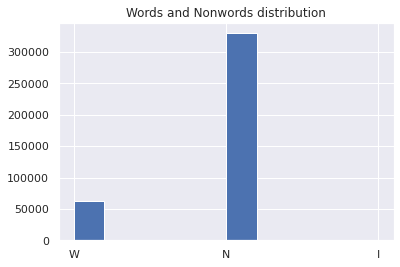

In [24]:
divi = words['lexicality'].value_counts()
plt.hist(x=words['lexicality'])
plt.title("Words and Nonwords distribution")
plt.savefig(PATH+"graphs/W_N_ratio.png", bbox_inches='tight')
plt.show()

In [32]:
real_words = words[words['lexicality']=='W']['spelling']
non_words = words[words['lexicality']=='N']['spelling']

In [ ]:
real_length = []
for a in real_words:
    if (type(a) == type("sr")):
        real_length.append(len(a))
    else:
        print(a)

non_length = []
for a in non_words:
    if (type(a) == type("sr")):
        non_length.append(len(a))
    else:
        print(a)

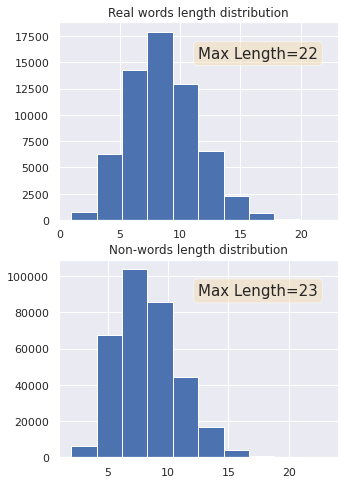

In [73]:
fig, ax = plt.subplots(2,1, figsize=(5,8))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

ax[0].hist(real_length, bins=10)
ax[0].set_title("Real words length distribution")
ax[0].text(0.5, 0.88, "Max Length=%.d"%(max(real_length)), transform=ax[0].transAxes, fontsize=15,
        verticalalignment='top', bbox=props)



ax[1].hist(non_length, bins=10)
ax[1].set_title("Non-words length distribution")
ax[1].text(0.5, 0.88, "Max Length=%.d"%(max(non_length)), transform=ax[1].transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

fig.savefig(PATH+"graphs/length_distr.png", bbox_inches='tight')
plt.show()

In [69]:
import random
non_words_selected = random.sample(list(non_words), len(real_words))

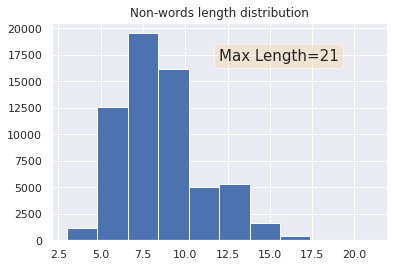

In [74]:
non_length_selected = []
for a in non_words_selected:
    if (type(a) == type("sr")):
        non_length_selected.append(len(a))
    else:
        print(a)

fig, ax = plt.subplots()
ax.hist(non_length_selected, bins=10)
ax.set_title("Non-words length distribution")
ax.text(0.5, 0.88, "Max Length=%.d"%(max(non_length_selected)), transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

fig.savefig(PATH+"graphs/nword_after_reduction_distr.png", bbox_inches='tight')
plt.show()

## Making the actual DataSet class

In [119]:
from torch.utils.data import Dataset
import torch

<p> In order to make the dataset we need to encode the words in some way. We will use a simple method: simply assigning a binary vector to each letter, then putting together all the vector that make a word, eventually adding 0s at the end if the word is shorter that the longest word in the dataset</p>

In [77]:
def word_to_vec(word, max_length):
    n = len(word)
    vec = ''
    for i in range(n):
        cur_char = word[i]
        idx = ord(cur_char) - 97
        tmp = (str(0)*idx) + str(1) + (str(0)*(25-idx))
        vec = vec + tmp
    if n < max_length:
        vec += str(0)*26*(max_length - n)
    return vec

As it should be the two words *hello* and *hallo* have only one difference.

In [81]:
print(word_to_vec('hello', 5))
print(word_to_vec('hallo', 5))

0000000100000000000000000000001000000000000000000000000000000001000000000000000000000000010000000000000000000000000000100000000000
0000000100000000000000000010000000000000000000000000000000000001000000000000000000000000010000000000000000000000000000100000000000


Now we need a basic function to make the labels vector.

In [82]:
def label_maker(lexicality):
    if lexicality == 'W':
        return [1,0]
    elif lexicality == 'N':
        return [0,1]

In [83]:
label_maker('W')

[1, 0]

In [89]:
print(word_to_vec(non_words_selected[0],len(non_words_selected[0])), '\n', non_words_selected[0])
print(word_to_vec(real_words[0],len(real_words[0])), '\n', real_words[0])

001000000000000000000000000000000000000010000000000000000000000000000001000000001000000000000000000000000000100000000000000000000000000000000000000001000000000000001000000000000000000001000000000000000000000000000000000000000010000000 
 cotcetids
00100000000000000000000000000000000001000000000000000000100000000000000000000010000000000000000000000000000000000000000001000000000000100000000000000000000000000000000000000100000000 
 clearer


We can now define the Dataset class in the standard way.

In [114]:
class WordsDataset(Dataset):

    def __init__(self):
        self.samples = []

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input = self.samples[idx][0]
        label = self.samples[idx][1]
        sample = [input, label]
        return sample
    
    def __addsample__(self, spelling, lexicality, max_length=22):
        if (type(spelling) == type("str")):
            input = word_to_vec(spelling, max_length=max_length)
            label = label_maker(lexicality)
            self.samples.append([input, label])
        else:
            print("Something Strange:", end='\t')
            print(spelling)

    def __removesample__(self, idx=0, value=None):
        '''
        If value is something, the element corresponding to that value is removed.
        Else the element at index idx is popped.
        '''
        if (value is not None):
            self.samples.remove(value)
        else:
            self.samples.pop(0)
        

In [115]:
dataset = WordsDataset()

The dataset is now empty, we can fill it with all our words.

In [116]:
for w in real_words:
    dataset.__addsample__(w, 'W')

for w in non_words_selected:
    dataset.__addsample__(w, 'N')

Something Strange:	nan
Something Strange:	[7, 8, 5, 4, 11, 4, 11, 6, 11, 11, 11, 10, 6, 9, 8, 13, 10, 6, 7, 9, 8, 7, 7, 12, 7, 10, 5, 9, 9, 7, 9, 12, 3, 6, 9, 11, 4, 11, 9, 4, 7, 8, 9, 6, 6, 17, 8, 8, 11, 15, 8, 8, 12, 6, 9, 6, 4, 7, 8, 12, 11, 9, 3, 10, 8, 8, 11, 5, 11, 11, 9, 6, 9, 5, 7, 12, 9, 8, 8, 9, 13, 7, 6, 9, 5, 10, 9, 12, 8, 7, 9, 11, 6, 13, 7, 7, 11, 9, 7, 9, 12, 9, 9, 14, 9, 7, 10, 10, 14, 13, 7, 7, 7, 12, 8, 11, 8, 8, 6, 15, 6, 13, 9, 5, 6, 6, 10, 8, 6, 8, 3, 11, 10, 5, 13, 10, 11, 8, 6, 9, 9, 10, 10, 6, 10, 12, 4, 6, 8, 11, 12, 9, 7, 10, 9, 12, 7, 11, 7, 9, 11, 10, 11, 9, 5, 5, 16, 8, 6, 13, 8, 11, 11, 14, 16, 12, 14, 7, 9, 6, 4, 5, 9, 6, 8, 12, 8, 13, 11, 10, 13, 6, 8, 12, 7, 8, 5, 9, 6, 6, 12, 13, 9, 6, 7, 9, 17, 7, 10, 14, 11, 7, 7, 6, 4, 11, 4, 6, 10, 11, 7, 10, 5, 10, 10, 6, 9, 7, 2, 6, 4, 8, 8, 6, 8, 4, 11, 5, 14, 6, 11, 4, 7, 10, 11, 13, 12, 9, 7, 6, 8, 4, 8, 9, 10, 5, 6, 9, 5, 8, 7, 15, 9, 9, 7, 9, 11, 10, 9, 8, 13, 9, 9, 9, 7, 4, 6, 10, 8, 12, 11, 5, 7, 6, 15, 6,

Checking if all went right.

In [118]:
print(len(real_words))
print(len(non_words_selected))
print(dataset.__len__())

61855
61855
123708


## Creating and Saving the training and test set
We will divide the dataset into training and testing.<br>
We use 80% of the dataset as training and the remaining 20% as test.

In [120]:
trainset, testset = torch.utils.data.random_split(dataset, [100000, 23708])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32)
testloader = torch.utils.data.DataLoader(testset, batch_size=32)

In [122]:
torch.save(trainloader, PATH+"trainloader.pth")
torch.save(testloader, PATH+"testloader.pth")